In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import math
from typing import Optional, Tuple, List
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [64]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
"""
awkward bunch of math stuff which essentially means it encodes everythings relative and absolute position in the protein sequence
"""

def add_positional_encoding(x):
    batch_size, seq_len, d_model = x.shape
    
    # Create positional encoding
    pe = torch.zeros(seq_len, d_model, device=x.device)
    position = torch.arange(0, seq_len, dtype=torch.float, device=x.device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=x.device).float() * 
                        (-math.log(10000.0) / d_model))
    
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    # Add to input and return
    return x + pe.unsqueeze(0)

In [ ]:
"""
Encodes the model so that the model

Preserves relative order and distances between timesteps,

And generalizes well, even to unseen timesteps.
"""

def create_time_embedding(time, dim):
    device = time.device
    half_dim = dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    return embeddings

In [ ]:
"""
Each token is projected into three vectors: Query, Key, and Value - attend (Q), how it can be attended to (K), and what info it carries (V)

Computes attention scores between all pairs of tokens in the sequence for each head.

attention output for each token by aggregating values V weighted by attention scores.

Recombines all num_heads outputs back into one tensor with shape [batch_size, seq_len, d_model].
"""
def multi_head_attention(x, w_q, w_k, w_v, w_o, dropout_layer, num_heads, mask=None):
    batch_size, seq_len, d_model = x.shape
    d_k = d_model // num_heads
    
    # Linear transformations and reshape
    Q = w_q(x).view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)
    K = w_k(x).view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)
    V = w_v(x).view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)
    
    # Scaled dot-product attention
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    
    if mask is not None:
        # Reshape mask to match scores dimensions: [batch_size, 1, 1, seq_len]
        mask = mask.unsqueeze(1).unsqueeze(2)  # [batch_size, 1, 1, seq_len]
        scores = scores.masked_fill(mask == 0, -1e9)
    
    attention_weights = F.softmax(scores, dim=-1)
    attention_weights = dropout_layer(attention_weights)
    
    # Apply attention to values
    context = torch.matmul(attention_weights, V)
    
    # Concatenate heads and put through final linear layer
    context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
    
    return w_o(context)

In [ ]:
"""
Applies multi-head attention with residual connection
Applies feed-forward network with residual connection
Uses layer normalization
"""

def transformer_block(x, attention_layers, norm1, norm2, feed_forward, mask=None):
    # Self-attention with residual connection
    attn_output = multi_head_attention(x, attention_layers['w_q'], attention_layers['w_k'], 
                                     attention_layers['w_v'], attention_layers['w_o'], 
                                     attention_layers['dropout'], attention_layers['num_heads'], mask)
    x = norm1(x + attn_output)
    
    # Feed-forward with residual connection
    ff_output = feed_forward(x)
    x = norm2(x + ff_output)
    
    return x

In [ ]:
"""
This function embeds the input protein sequence and adds positional encoding, then creates conditioning vectors from the timestep and temperature which get added to every sequence 
position. It processes this conditioned sequence through multiple transformer blocks, then splits the output into sequence predictions (via output projection) and temperature
 predictions (via global pooling and a temperature head).
"""

def rubisco_diffusion_forward(x, timesteps, temperature, model_components, mask=None):
    """
    RuBisCO Diffusion Model forward pass as a function
    
    Args:
        x: Input sequences [batch_size, seq_len]
        timesteps: Diffusion timesteps [batch_size]
        temperature: Target temperatures [batch_size, 1]
        model_components: Dictionary containing all model layers
        mask: Attention mask [batch_size, seq_len]
    """
    batch_size, seq_len = x.shape
    d_model = model_components['d_model']
    
    # Amino acid embeddings with positional encoding
    x_embedded = model_components['amino_acid_embedding'](x)  # [batch_size, seq_len, d_model]
    x_embedded = add_positional_encoding(x_embedded)
    x_embedded = model_components['dropout'](x_embedded)
    
    # Time and temperature conditioning
    time_embed = create_time_embedding(timesteps, d_model)  # [batch_size, d_model]
    temp_embed = model_components['temp_embedding'](temperature)  # [batch_size, d_model]
    
    # Combine conditioning
    condition = torch.cat([time_embed, temp_embed], dim=-1)  # [batch_size, 2*d_model]
    condition = model_components['condition_proj'](condition)  # [batch_size, d_model]
    
    # Add conditioning to sequence (broadcast across sequence length)
    condition = condition.unsqueeze(1).expand(-1, seq_len, -1)
    x_embedded = x_embedded + condition
    
    # Transformer blocks
    hidden = x_embedded
    for i in range(len(model_components['transformer_blocks'])):
        block_components = model_components['transformer_blocks'][i]
        hidden = transformer_block(hidden, block_components['attention'], 
                                 block_components['norm1'], block_components['norm2'], 
                                 block_components['feed_forward'], mask)
    
    # Output projections
    sequence_logits = model_components['output_projection'](hidden)  # [batch_size, seq_len, vocab_size]
    
    # Global pooling for temperature prediction
    if mask is not None:
        mask_expanded = mask.unsqueeze(-1).expand_as(hidden)
        hidden_masked = hidden * mask_expanded
        seq_len_actual = mask.sum(dim=1, keepdim=True).float()
        pooled = hidden_masked.sum(dim=1) / seq_len_actual  # [batch_size, d_model]
    else:
        pooled = hidden.mean(dim=1)  # [batch_size, d_model]
    
    temp_pred = model_components['temperature_head'](pooled)  # [batch_size, 1]
    
    return sequence_logits, temp_pred

In [ ]:
'''
This seems sumer inefficient IDK

so essentially this builds a dictionary of the model including all components.

makes n transformer blocks by lopping through
'''

def create_model_components(vocab_size=21, d_model=256, num_heads=8, num_layers=6, d_ff=1024, dropout=0.1):
    components = {
        'd_model': d_model,
        'amino_acid_embedding': nn.Embedding(vocab_size, d_model),
        'temp_embedding': nn.Linear(1, d_model),
        'condition_proj': nn.Linear(d_model * 2, d_model),
        'output_projection': nn.Linear(d_model, vocab_size),
        'temperature_head': nn.Linear(d_model, 1),
        'dropout': nn.Dropout(dropout),
        'transformer_blocks': []
    }
    
    # Create transformer blocks
    for _ in range(num_layers):
        block = {
            'attention': {
                'w_q': nn.Linear(d_model, d_model),
                'w_k': nn.Linear(d_model, d_model),
                'w_v': nn.Linear(d_model, d_model),
                'w_o': nn.Linear(d_model, d_model),
                'dropout': nn.Dropout(dropout),
                'num_heads': num_heads
            },
            'norm1': nn.LayerNorm(d_model),
            'norm2': nn.LayerNorm(d_model),
            'feed_forward': nn.Sequential(
                nn.Linear(d_model, d_ff),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(d_ff, d_model),
                nn.Dropout(dropout)
            )
        }
        components['transformer_blocks'].append(block)
    
    return components

In [ ]:
"""
OK so its in the name

beta value is a tensor which schedules the amount of noise added at each time step, it sets early time steps to have little noise and gradually increase it until it gets to 0.02

alpha is how much of the signal from the previous timestep is lost in the noise process

Alpha bar is how much of the original signal is lost 
"""

def create_diffusion_schedule(num_timesteps=1000):
    betas = torch.linspace(0.0001, 0.02, num_timesteps)
    alphas = 1.0 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    return betas, alphas, alpha_bars

In [ ]:
"""
Ok so what this does essentially is get the alpha bar for each appropriate timestep then gets a appropatire string of noise. 
its then randomly, according to probability determined by the alpha bar mixed the random noise string and the actual protein
"""

def add_noise(x_0, t, alpha_bars, vocab_size=21):
    batch_size, seq_len = x_0.shape
    device = x_0.device
    
    # Move diffusion schedule to the same device if needed
    if alpha_bars.device != device:
        alpha_bars = alpha_bars.to(device)
    
    # Get alpha_bar for each timestep
    alpha_bar = alpha_bars[t]  # [batch_size]
    
    # Sample noise (categorical noise for discrete sequences)
    noise = torch.randint(0, vocab_size, (batch_size, seq_len), device=device)
    
    # Mix original and noise based on alpha_bar
    alpha_bar = alpha_bar.unsqueeze(1).expand(-1, seq_len)  # [batch_size, seq_len]
    
    # Bernoulli sampling: keep original with prob alpha_bar, use noise otherwise
    keep_original = torch.bernoulli(alpha_bar).long()
    x_t = keep_original * x_0 + (1 - keep_original) * noise
    
    return x_t, noise



In [ ]:
"""
gets a random noise timestep
"""

def sample_timesteps(batch_size, num_timesteps, device):
    return torch.randint(0, num_timesteps, (batch_size,), device=device).long()

In [ ]:
"""
Loop through each individual sequence/timestep pair in a batch.

convert the sequence into its index token

it pads it so its an appropriate length

masks its so it is 1 for each real amino acid character 0 for each padding token

Accumulate results
"""
def create_protein_batch(sequences, temperatures, amino_acid_to_idx, max_len=600):
    batch_sequences = []
    batch_temperatures = []
    batch_masks = []
    
    for sequence, temperature in zip(sequences, temperatures):
        # Convert sequence to indices
        seq_indices = [amino_acid_to_idx.get(aa, 0) for aa in sequence]  # 0 for unknown
        
        # Pad or truncate to max_len
        if len(seq_indices) < max_len:
            seq_indices.extend([0] * (max_len - len(seq_indices)))  # pad with 0
        else:
            seq_indices = seq_indices[:max_len]
        
        # Create attention mask (1 for real tokens, 0 for padding)
        mask = [1 if i < len(sequence) else 0 for i in range(max_len)]
        
        batch_sequences.append(seq_indices)
        batch_temperatures.append(temperature)
        batch_masks.append(mask)
    
    return {
        'sequence': torch.tensor(batch_sequences, dtype=torch.long),
        'temperature': torch.tensor(batch_temperatures, dtype=torch.float32).unsqueeze(-1),
        'mask': torch.tensor(batch_masks, dtype=torch.float32)
    }


In [75]:
def process_single_protein(sequence, temperature, amino_acid_to_idx, max_len=600):
    # Convert sequence to indices
    seq_indices = [amino_acid_to_idx.get(aa, 0) for aa in sequence]  # 0 for unknown
    
    # Pad or truncate to max_len
    if len(seq_indices) < max_len:
        seq_indices.extend([0] * (max_len - len(seq_indices)))  # pad with 0
    else:
        seq_indices = seq_indices[:max_len]
    
    # Create attention mask (1 for real tokens, 0 for padding)
    mask = [1 if i < len(sequence) else 0 for i in range(max_len)]
    
    return {
        'sequence': torch.tensor(seq_indices, dtype=torch.long),
        'temperature': torch.tensor([temperature], dtype=torch.float32),
        'mask': torch.tensor(mask, dtype=torch.float32)
    }

In [ ]:
# This essentially makes two seperate dictionaries
# aa_to_idx maps the values of the amino acids to its index - encoding
# idx_to_aa maps the values of the index to its amino acids - decoding


def create_amino_acid_vocab():
    amino_acids = ['PAD', 'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 
                   'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    aa_to_idx = {aa: idx for idx, aa in enumerate(amino_acids)}
    idx_to_aa = {idx: aa for idx, aa in enumerate(amino_acids)}
    return aa_to_idx, idx_to_aa

In [ ]:
"""
Simply loads the data from csv puts in in panda. Locates the sequence data and temp data. ensures that we have good data points. 

Exception  needs to be straight up removed. There is no need for dummy data
"""

def load_protein_data(csv_path: str) -> Tuple[List[str], List[float]]:
    try:
        df = pd.read_csv(csv_path)
        print(f"Loaded data with columns: {df.columns.tolist()}")
        print(f"Data shape: {df.shape}")
        
        # Try to identify sequence and temperature columns
        sequence_col = None
        temp_col = None
        
        for col in df.columns:
            if 'seq' in col.lower():
                sequence_col = col
            elif any(temp_name in col.lower() for temp_name in ['temp', 'tm', 'melt']):
                temp_col = col
        
        if sequence_col is None:
            print("Available columns:", df.columns.tolist())
            raise ValueError("Could not find sequence column. Please ensure column name contains 'seq'")
        
        if temp_col is None:
            print("Available columns:", df.columns.tolist())
            raise ValueError("Could not find temperature column. Please ensure column name contains 'temp', 'tm', or 'melt'")
        
        # Clean the data
        df = df.dropna(subset=[sequence_col, temp_col])
        
        sequences = df[sequence_col].tolist()
        temperatures = df[temp_col].tolist()
        
        # Filter out sequences that are too short or too long
        filtered_sequences = []
        filtered_temperatures = []
        
        for seq, temp in zip(sequences, temperatures):
            if isinstance(seq, str) and 50 <= len(seq) <= 600:  # reasonable protein length
                # Clean sequence (remove non-amino acid characters)
                cleaned_seq = ''.join([c for c in seq.upper() if c in 'ARNDCQEGHILKMFPSTWYV'])
                if len(cleaned_seq) >= 50:
                    filtered_sequences.append(cleaned_seq)
                    filtered_temperatures.append(float(temp))
        
        print(f"Filtered to {len(filtered_sequences)} valid sequences")
        return filtered_sequences, filtered_temperatures
        
    except Exception as e:
        print(f"Error loading data: {e}")
        # Return dummy data for testing
        print("Using dummy data for testing...")
        dummy_sequences = [
            'MVKKTFVSLVAAASCLAGVSVAAAVATAAADAPAAGTAADAAADLASAEAGLVPQGAAHVAGAATVAGTVVAASAALAADADAGAAEVAGAEAVVVAGAADSAAQSTVAAAAEAVVAGAAGAAGAGTVGSETVAGAAAGAAAGAETVEQAADMGTVVTASGTAGAAAAAEAGAAGAATGAAGGTGAAGAAGAAGAAGAAGAGAGAGA',
            'MAAKLVFSLVAAAFCLAGVSVAAAVATAAADAPAAGTAADAAADLASAEAGLVPQGAAHVAGAATVAGTVVAASAALAADADAGAAEVAGAEAVVVAGAADSAAQSTVAAAAEAVVAGAAGAAGAGTVGSETVAGAAAGAAAGAETVEQAADMGTVVTASGTAGAAAAAEAGAAGAATGAAGGTGAAGAAGAAGAAGAAGAGAGA',
            'MAKKLVFSLVAAAFCLAGVSVAAAVATAAADAPAAGTAADAAADLASAEAGLVPQGAAHVAGAATVAGTVVAASAALAADADAGAAEVAGAEAVVVAGAADSAAQSTVAAAAEAVVAGAAGAAGAGTVGSETVAGAAAGAAAGAETVEQAADMGTVVTASGTAGAAAAAEAGAAGAATGAAGGTGAAGAAGAAGAAGAAGAGAGA'
        ]
        dummy_temperatures = [55.0, 65.0, 75.0]
        return dummy_sequences, dummy_temperatures

In [ ]:
"""
"""

def train_diffusion_model(model_components, train_data, val_data, 
                         diffusion_schedule, num_epochs=100, 
                         learning_rate=1e-4, device=torch.device('cpu')):

    for key, component in model_components.items():
        if isinstance(component, (nn.Module, torch.Tensor)):
            if hasattr(component, 'to'):
                model_components[key] = component.to(device)
        elif isinstance(component, list):  # transformer blocks
            for block in component:
                for block_key, block_component in block.items():
                    if isinstance(block_component, dict):  # attention dict
                        for att_key, att_component in block_component.items():
                            if hasattr(att_component, 'to'):
                                block_component[att_key] = att_component.to(device)
                    elif hasattr(block_component, 'to'):
                        block[block_key] = block_component.to(device)
    
    # Get all parameters for optimizer
    all_params = []
    def collect_params(component):
        if hasattr(component, 'parameters'):
            all_params.extend(component.parameters())
        elif isinstance(component, dict):
            for v in component.values():
                collect_params(v)
        elif isinstance(component, list):
            for item in component:
                collect_params(item)
    
    collect_params(model_components)
    
    optimizer = optim.AdamW(all_params, lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    betas, alphas, alpha_bars = diffusion_schedule
    alpha_bars = alpha_bars.to(device)
    
    train_losses = []
    val_losses = []
    
    print("Starting training...")
    
    # Fix: Use the actual number of sequences
    num_train_sequences = len(train_data['sequences'])
    num_val_sequences = len(val_data['sequences'])
    batch_size = 8
    
    print(f"Training sequences: {num_train_sequences}")
    print(f"Validation sequences: {num_val_sequences}")
    
    for epoch in range(num_epochs):
        # Training phase
        for component in model_components.values():
            if hasattr(component, 'train'):
                component.train()
        
        train_loss = 0.0
        num_batches = max(1, num_train_sequences // batch_size)  # Ensure at least 1 batch
        
        for batch_idx in range(num_batches):
            # Get batch
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_train_sequences)
            
            batch_sequences = train_data['sequences'][start_idx:end_idx]
            batch_temps = train_data['temperatures'][start_idx:end_idx]
            
            # Skip if batch is empty
            if len(batch_sequences) == 0:
                continue
            
            # Process batch
            batch = create_protein_batch(batch_sequences, batch_temps, 
                                       train_data['amino_acid_to_idx'])
            
            sequences = batch['sequence'].to(device)
            temperatures = batch['temperature'].to(device)
            masks = batch['mask'].to(device)
            
            actual_batch_size = sequences.shape[0]
            
            # Sample timesteps and add noise
            timesteps = sample_timesteps(actual_batch_size, 1000, device)
            noisy_sequences, _ = add_noise(sequences, timesteps, alpha_bars)
            
            # Forward pass
            pred_logits, pred_temp = rubisco_diffusion_forward(
                noisy_sequences, timesteps, temperatures, model_components, masks)
            
            # Calculate loss - Fix: use vocab_size (21) instead of d_model
            seq_loss = F.cross_entropy(
                pred_logits.view(-1, 21),  # vocab_size = 21
                sequences.view(-1),
                reduction='none'
            )
            seq_loss = seq_loss.view(actual_batch_size, -1) * masks
            seq_loss = seq_loss.sum() / masks.sum()
            
            temp_loss = F.mse_loss(pred_temp, temperatures)
            total_loss = seq_loss + 0.1 * temp_loss
            
            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(all_params, max_norm=1.0)
            optimizer.step()
            
            train_loss += total_loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}: Loss = {total_loss.item():.4f}')
        
        # Validation phase
        for component in model_components.values():
            if hasattr(component, 'eval'):
                component.eval()
        
        val_loss = 0.0
        val_batches = max(1, num_val_sequences // batch_size)  # Ensure at least 1 batch
        
        with torch.no_grad():
            for batch_idx in range(val_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, num_val_sequences)
                
                batch_sequences = val_data['sequences'][start_idx:end_idx]
                batch_temps = val_data['temperatures'][start_idx:end_idx]
                
                # Skip if batch is empty
                if len(batch_sequences) == 0:
                    continue
                
                batch = create_protein_batch(batch_sequences, batch_temps,
                                           val_data['amino_acid_to_idx'])
                
                sequences = batch['sequence'].to(device)
                temperatures = batch['temperature'].to(device)
                masks = batch['mask'].to(device)
                
                actual_batch_size = sequences.shape[0]
                timesteps = sample_timesteps(actual_batch_size, 1000, device)
                noisy_sequences, _ = add_noise(sequences, timesteps, alpha_bars)
                
                pred_logits, pred_temp = rubisco_diffusion_forward(
                    noisy_sequences, timesteps, temperatures, model_components, masks)
                
                seq_loss = F.cross_entropy(
                    pred_logits.view(-1, 21),  # vocab_size = 21
                    sequences.view(-1),
                    reduction='none'
                )
                seq_loss = seq_loss.view(actual_batch_size, -1) * masks
                seq_loss = seq_loss.sum() / masks.sum()
                
                temp_loss = F.mse_loss(pred_temp, temperatures)
                total_loss = seq_loss + 0.1 * temp_loss
                
                val_loss += total_loss.item()
        
        train_loss /= num_batches
        val_loss /= val_batches
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        scheduler.step()
        
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')
    
    return train_losses, val_losses

In [79]:
def generate_sequences(model_components, diffusion_schedule, target_temperatures,
                      sequence_length=300, num_samples=5, device=torch.device('cpu'),
                      idx_to_aa=None):
    """
    Generate protein sequences using simplified diffusion model
    """
    betas, alphas, alpha_bars = diffusion_schedule
    num_timesteps = len(betas)
    vocab_size = 21
    
    # Set all components to eval mode
    for component in model_components.values():
        if hasattr(component, 'eval'):
            component.eval()
    
    generated_sequences = []
    
    with torch.no_grad():
        for target_temp in target_temperatures:
            for _ in range(num_samples):
                # Start with random noise
                x = torch.randint(1, vocab_size, (1, sequence_length), device=device)
                target_temp_tensor = torch.tensor([[target_temp]], device=device, dtype=torch.float32)
                
                # Reverse diffusion process
                for t in reversed(range(num_timesteps)):
                    timestep = torch.tensor([t], device=device, dtype=torch.long)
                    
                    # Predict clean sequence
                    pred_logits, _ = rubisco_diffusion_forward(
                        x, timestep, target_temp_tensor, model_components)
                    
                    # Sample from predicted distribution
                    probs = F.softmax(pred_logits, dim=-1)
                    x = torch.multinomial(probs.view(-1, vocab_size), 1).view(1, -1)
                
                # Convert to amino acid sequence
                if idx_to_aa is not None:
                    sequence = ''.join([idx_to_aa[idx.item()] for idx in x[0] if idx.item() != 0])
                    generated_sequences.append(sequence)
                else:
                    generated_sequences.append(x[0].cpu().numpy())
    
    return generated_sequences



In [80]:
def generate_single_sequence(model_components, diffusion_schedule, target_temp,
                           sequence_length=300, device=torch.device('cpu'),
                           idx_to_aa=None):
    """Generate a single protein sequence"""
    betas, alphas, alpha_bars = diffusion_schedule
    num_timesteps = len(betas)
    vocab_size = 21
    
    # Set all components to eval mode
    for component in model_components.values():
        if hasattr(component, 'eval'):
            component.eval()
    
    with torch.no_grad():
        # Start with random noise
        x = torch.randint(1, vocab_size, (1, sequence_length), device=device)
        target_temp_tensor = torch.tensor([[target_temp]], device=device, dtype=torch.float32)
        
        # Reverse diffusion process
        for t in reversed(range(num_timesteps)):
            timestep = torch.tensor([t], device=device, dtype=torch.long)
            
            # Predict clean sequence
            pred_logits, _ = rubisco_diffusion_forward(
                x, timestep, target_temp_tensor, model_components)
            
            # Sample from predicted distribution
            probs = F.softmax(pred_logits, dim=-1)
            x = torch.multinomial(probs.view(-1, vocab_size), 1).view(1, -1)
        
        # Convert to amino acid sequence
        if idx_to_aa is not None:
            sequence = ''.join([idx_to_aa[idx.item()] for idx in x[0] if idx.item() != 0])
            return sequence
        else:
            return x[0].cpu().numpy()

In [81]:
def plot_training_curves(train_losses, val_losses, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()

def quick_plot(losses, title="Loss"):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, color='blue', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

Using device: cuda
Loaded data with columns: ['Entry', 'Protein names', 'Gene Names', 'Organism', 'Length', 'EC number', 'Gene Ontology (GO)', 'Keywords', 'Sequence', 'UNIPROT_ID', 'Tm_(C)']
Data shape: (275, 11)
Filtered to 243 valid sequences
Model has 4881430 parameters
Starting training...
Starting training...
Training sequences: 194
Validation sequences: 49
Starting training...
Training sequences: 194
Validation sequences: 49
Epoch 0, Batch 0: Loss = 622.5971
Epoch 0, Batch 0: Loss = 622.5971
Epoch 0, Batch 10: Loss = 550.7206
Epoch 0, Batch 10: Loss = 550.7206
Epoch 0, Batch 20: Loss = 434.0396
Epoch 0, Batch 20: Loss = 434.0396
Epoch 1/50: Train Loss = 519.2177, Val Loss = 504.6666
Epoch 1, Batch 0: Loss = 482.7177
Epoch 1/50: Train Loss = 519.2177, Val Loss = 504.6666
Epoch 1, Batch 0: Loss = 482.7177
Epoch 1, Batch 10: Loss = 538.2560
Epoch 1, Batch 10: Loss = 538.2560
Epoch 1, Batch 20: Loss = 424.8104
Epoch 1, Batch 20: Loss = 424.8104
Epoch 2/50: Train Loss = 492.2733, Val 

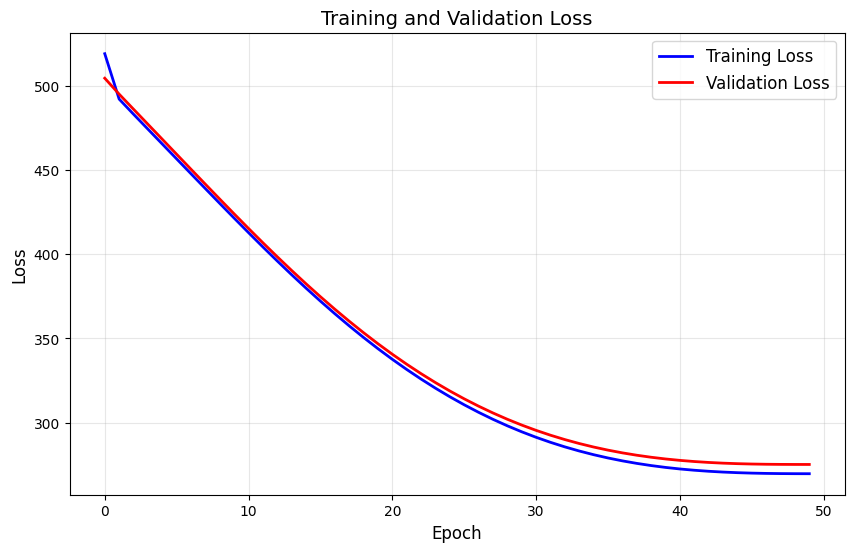


Generating thermostable sequences...

Generated sequence for 70.0°C:
Length: 300
Sequence: LLFFLFENVRAHEAVGALVWNRLGALGVHRGKVLMLLITGRPEHEPLAATRRFAAIQVRIGVAEHAPAWRAAGRYEGDGIPRGPLVFANALERRAPVGLL...

Generated sequence for 70.0°C:
Length: 300
Sequence: MGKDVGRVGVALTVKPEQAGREPGGAMALLRVELAGRPFAANEVHVTMKGVLFAEGQRYPLILLLGQDGGRALAGSGERGDGKVEDAAELERAEAAFREM...

Generated sequence for 70.0°C:
Length: 300
Sequence: LKAKAVPAEPFRLGKEAQLTALVEKESLSVEKVRDTRANLSKTPVFLVINEKPRTELTIHLAPVLYDSIVGAPTLKVPVVALFNAEKLVLTEETSGDRDF...

Generated sequence for 80.0°C:
Length: 300
Sequence: LDLAPLTGIEAQSAELVEWRDPMANSDAPEKLREGAIVRYQREVTDRMAYSNAQLGRSPREDIYEGVAVIPPVPHVERDEPRRQGLYSPYVPISAARPAG...

Generated sequence for 80.0°C:
Length: 300
Sequence: PSSMLKRVVQESVPPNKLGVNRNTVGIRVDADELAADRGLVFWDEEAAVFLKRNAAHSARVEREELAELLAKLNEIGLRSTWLLNVIEDRNRHGEIIVPA...

Generated sequence for 80.0°C:
Length: 300
Sequence: ASLKVHTSKYGVVNQYAMRRRGNLNELVEAFGLFRVENEVEPILIGDQDFLARVRVAAQLRMKKARASEPERQIRGPEAMGQGFAKGMHYVKFRIKLPGA...

Generated seq

In [82]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load data
csv_path = "uniprot_with_Tm.csv"
sequences, temperatures = load_protein_data(csv_path)

# Create vocabulary
aa_to_idx, idx_to_aa = create_amino_acid_vocab()

# Split data
train_sequences, val_sequences, train_temps, val_temps = train_test_split(
    sequences, temperatures, test_size=0.2, random_state=42
)

# Create model components
model_components = create_model_components(
    vocab_size=21,
    d_model=256,
    num_heads=8,
    num_layers=6,
    d_ff=1024,
    dropout=0.1
)

# Create diffusion schedule
diffusion_schedule = create_diffusion_schedule(num_timesteps=1000)

# Count parameters
total_params = 0
def count_params(component):
    global total_params
    if hasattr(component, 'parameters'):
        total_params += sum(p.numel() for p in component.parameters())
    elif isinstance(component, dict):
        for v in component.values():
            count_params(v)
    elif isinstance(component, list):
        for item in component:
            count_params(item)

count_params(model_components)
print(f"Model has {total_params} parameters")

# Prepare data
train_data = {
    'sequences': train_sequences,
    'temperatures': train_temps,
    'amino_acid_to_idx': aa_to_idx
}

val_data = {
    'sequences': val_sequences,
    'temperatures': val_temps,
    'amino_acid_to_idx': aa_to_idx
}

# Train model
print("Starting training...")
train_losses, val_losses = train_diffusion_model(
    model_components, train_data, val_data, diffusion_schedule,
    num_epochs=50, learning_rate=1e-4, device=device
)

# Plot training curves
plot_training_curves(train_losses, val_losses, save_path="training_curves.png")

# Generate new sequences
print("\nGenerating thermostable sequences...")
target_temperatures = [70.0, 80.0, 90.0]
generated_sequences = generate_sequences(
    model_components, diffusion_schedule, target_temperatures,
    sequence_length=300, num_samples=3, device=device, idx_to_aa=idx_to_aa
)

# Display generated sequences
for i, seq in enumerate(generated_sequences):
    temp_idx = i // 3
    print(f"\nGenerated sequence for {target_temperatures[temp_idx]}°C:")
    print(f"Length: {len(seq)}")
    print(f"Sequence: {seq[:100]}..." if len(seq) > 100 else f"Sequence: {seq}")

# Save model components
save_data = {
    'model_components': model_components,
    'diffusion_schedule': diffusion_schedule,
    'aa_to_idx': aa_to_idx,
    'idx_to_aa': idx_to_aa,
    'config': {
        'vocab_size': 21,
        'd_model': 256,
        'num_heads': 8,
        'num_layers': 6,
        'd_ff': 1024,
        'dropout': 0.1
    }
}

torch.save(save_data, 'rubisco_diffusion_model.pth')
print("\nModel saved as 'rubisco_diffusion_model.pth'")
print("Training completed!")